In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import json
from scipy.signal import argrelextrema
from scipy import ndimage
import ast
from scipy.spatial.distance import cdist
from scipy.signal import butter, lfilter, freqz, group_delay, filtfilt
from skvideo import io
from os import listdir
import pandas as pd
from scipy.interpolate import interp1d

/Users/ninawiedemann/anaconda/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [3]:
player_list = [0]
joints_for_cdist = np.arange(0,18,1)
important_joints = [0,3,6,7,8,9,10,11]
def color_video(json_array, vid_file, start = 0, cut_frame = True, end = 300, point = 8, printing =None, plotting=True):
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 170, 255],
              [0, 0, 0], 
          [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], 
              [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], \
          [170, 0, 255], [255, 0, 170], [255, 0, 85]]
    colors_string = ["blue", "green", "red", "tuerkis", "pink", "yellow", "orange", "black", "purple"]
    nr_joints =12
    #print(json_array.shape)
    #writer = cv2.VideoWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi",cv2.VideoWriter_fourcc(*"XVID") , 20, (500,800))

    #writer = io.FFmpegWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi", (10,800,500,3))
    #writer.open()
    video_capture = cv2.VideoCapture(vid_file)
    print(vid_file)
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, 100)
    arr = [] #np.zeros((100,800,500,3))

    
    # fig = plt.figure(figsize=(5, 15)) # for subplots
    for k in range(start, end):
        #print(k)
        if printing!=None:
            #print("dist_min",  "ratio_min")
            #print(colors_string[printing[k][0]], colors_string[printing[k][1]])
            print(printing[k])
        ret, frame = video_capture.read()
        if frame is None:
            print("end", k)
            break
        if len(np.array(json_array[k]).shape)==2:
            all_peaks = np.reshape(np.array(json_array[k]), (12, 1,2))
        else:
            all_peaks = np.array(json_array[k])
        #print(all_peaks.shape)
        
        if cut_frame:
            canvas = frame[top_b:bottom_b, left_b:right_b] # cv2.imread(f) # B,G,R order
        else: 
            canvas = frame
        oriImg = canvas.copy()
        
        for i in range(len(all_peaks)):
            #print("person", all_peaks[i])
            for j in range(len(all_peaks[i])):
                cv2.circle(canvas, (int(all_peaks[i,j,0]),int(all_peaks[i,j,1])) , point, colors[i], thickness=-1)

        to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
        arr.append(to_plot[:,:,[2,1,0]])
        if plotting:
            plt.imshow(to_plot[:,:,[2,1,0]])
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 12)
            plt.show()

    """
    # for subplots
    ax = fig.add_subplot(end-start,1, k-start+1)
        plt.imshow(to_plot[:,:,[2,1,0]])
        plt.title("frame "+str(k))
        
    plt.tight_layout()
    plt.show()
    """
    arr = np.array(arr)
    return arr

def color_video_all_in_one(json_array, vid_file, start = 0, cut_frame = True, end = 300, point = 4, printing =None, plotting=True):
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 170, 255],
              [0, 0, 0], 
          [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], 
              [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], \
          [170, 0, 255], [255, 0, 170], [255, 0, 85]]
    colors_string = ["blue", "green", "red", "tuerkis", "pink", "yellow", "orange", "black", "purple"]
    nr_joints =12
    #print(json_array.shape)
    #writer = cv2.VideoWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi",cv2.VideoWriter_fourcc(*"XVID") , 20, (500,800))

    #writer = io.FFmpegWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi", (10,800,500,3))
    #writer.open()
    video_capture = cv2.VideoCapture(vid_file)
    print(vid_file)
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    arr = [] #np.zeros((100,800,500,3))

    ret, canvas = video_capture.read()
    
    # fig = plt.figure(figsize=(5, 15)) # for subplots
    for k in range(start, end):
        #print(k)
        if printing!=None:
            #print("dist_min",  "ratio_min")
            #print(colors_string[printing[k][0]], colors_string[printing[k][1]])
            print(printing[k])
        
        if len(np.array(json_array[k]).shape)==2:
            all_peaks = np.reshape(np.array(json_array[k]), (12, 1,2))
        else:
            all_peaks = np.array(json_array[k])
        #print(all_peaks.shape)
        
        
        # oriImg = canvas.copy()
        
        for i in range(len(all_peaks)):
            #print("person", all_peaks[i])
            for j in range(len(all_peaks[i])):
                cv2.circle(canvas, (int(all_peaks[i,j,0]),int(all_peaks[i,j,1])) , point, colors[i], thickness=-1)

        # to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
        # arr.append(to_plot[:,:,[2,1,0]])
        if plotting:
            plt.imshow(canvas[:,:,[2,1,0]])
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 12)
            plt.show()
            
    plt.imshow(canvas[:,:,[2,1,0]])
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12, 12)
    plt.show()
    
def to_json(play, events_dic, save_path, position = None, pitchtype = None, frames_per_sec = 30):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    frames, joints, xy = play.shape
    dic={}
    dic["Pitching position"]= position
    dic["Pitch Type"] = pitchtype
    dic["device"] = "?"
    dic["deployment"] = "?"
    dic["frames"] = []
    for i in range(frames):
        dic_joints = {}
        #dic_joints["timestamp"] = int(round(start_time + (1000*i)/float(frames_per_sec)))
        for j in range(17): #joints):
            dic_xy = {}
            for k in range(xy):
                dic_xy[coordinates[k]] = play[i,j,k]
            dic_joints[joints_list[j]] = dic_xy
        dic_joints["events"]=[]
        for j in events_dic.keys():
            if i==events_dic[j]:
                dic_joints["events"].append({"timestamp": int(round(time.time() * 1000)), "name": j,"code": 1,
                                    "target_name": "Pitcher", "target_id": 1})
        dic["frames"].append(dic_joints)

    with open(save_path+".json", 'w') as outfile:
        json.dump(dic, outfile, indent=10)
            
def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle", "neck",
            "right_eye", "right_ear","left_eye", "left_ear"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list: #[:12]:
            l_coo = []
            # print("liste",list(fr.keys()), "joint", j, "in dic?", str(j) in list(fr.keys()), list(fr.keys())[-1])
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)
    return np.array(liste)

def smooth_estelle(x,window_len=6,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
    #print(len(x))
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    

    s = np.r_[x[window_len//2-1:0:-1],x,x[-1:-window_len//2:-1],x[-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    #print(w)
    
    y=np.convolve(w/w.sum(),x,mode='same')
    #print(len(y))
    return y

def kalmann(sequence):
    # intial parameters
    n_iter = len(sequence)
    sz = (n_iter,) # size of array
    #x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
    z = sequence #np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**3 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = sequence[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
    return xhat

def player_localization_old(df,frame,player,old_array, body_dist):
    #player2=player+'_player'
    dist=[]
    ratios = []
    zerrow2=np.where(old_array[:,0]!=0)[0]
    for i in range(np.asarray(df[player][frame]).shape[0]):
        zerrow1=np.where(np.asarray(df[player][frame])[i,:,0]!=0)[0]
        zerrow_all =np.intersect1d(zerrow1,zerrow2) # assume unique argument for speedup?
        zerrow = np.intersect1d(zerrow_all, important_joints)
        # print("leng", len(zerrow), zerrow)

        if len(zerrow)<2:
            dist.append(np.inf)
            ratios.append(np.inf)
            continue

        dist.append(np.linalg.norm(np.asarray(df[player][frame])[i,zerrow,:] - old_array[zerrow])/len(zerrow))

        p = df[player][frame][i]
        player_dist = cdist(p,p)

        def cut_nonzero(cdi, nonzero):
            cdi = (cdi[nonzero])
            cdi = np.swapaxes(cdi,0,1)
            cdi = cdi[nonzero]
            cdi = np.swapaxes(cdi,0,1)
            return cdi

        ratios.append(np.linalg.norm(cut_nonzero(body_dist, zerrow) - cut_nonzero(player_dist, zerrow))/len(zerrow))


    #print df[player][frame]

    if len(dist)==0:
        df[1][frame]=[[0,0] for i in range(18)]
        #print("ungleich", frame, np.argmin(ratios), np.argmin(dist))
    elif len(dist)==1:
        df[1][frame]= df[player][frame][0]
    else:
        #df[1][frame]=df[player][frame][np.argmin(smallest_dist[0])]
        smallest_dist = np.argsort(dist)
        argmin_list.append(smallest_dist) #[np.argmin(dist), np.argmin(ratios)])
        if dist[smallest_dist[1]] > 2*dist[smallest_dist[0]]:
            df[1][frame]=df[player][frame][smallest_dist[0]]
        else:
            if ratios[smallest_dist[0]]<ratios[smallest_dist[1]]: #smallest_dist[0]== np.argmin(ratios) or smallest_dist[1]==np.argmin(ratios):
                df[1][frame]=df[player][frame][smallest_dist[0]]
            else:
                df[1][frame]=[[0,0] for i in range(18)]
    array_stored=np.asarray(df[1][frame])
    array_stored[np.where(array_stored==0)]=old_array[np.where(array_stored==0)]

    joint_arr_cdist = np.array(array_stored)[joints_for_cdist]
    new_body_dist = cdist(joint_arr_cdist, joint_arr_cdist)
    old_array=array_stored
    return df, old_array, new_body_dist

def color_box(vid, bbox, ax, color = "red"):
    
    ax.add_patch(
    plt.Rectangle((int(bbox[0]), int(bbox[2])),
                  int(bbox[1]-bbox[0]), int(bbox[3]-bbox[2]), fill=False,
                  edgecolor=color, linewidth=3.5)
    )
    

def overlap(A, B):
    #print(A, B)
    if (A[0] > B[1]) or (A[1] < B[0]):
        #print(A[0], ">", B[1], "or", A[1], "<", B[0])
        return 0
    if (A[2] > B[3]) or (A[3] < B[2]):
        #print(A[2], ">", B[3], "or", A[3], "<", B[2])
        return 0
    I = [max(A[0], B[0]), min(A[1], B[1]), max(A[2], B[2]), min(A[3], B[3])]
    # color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", I, )
    # color_box(video_color_box, I, ax, color = "green")
    
    Aarea = abs((A[0]-A[1])*(A[2]-A[3]))
    Barea = abs((B[0]-B[1])*(B[2]-B[3]))
    Iarea = abs((I[0]-I[1])*(I[2]-I[3]))
    
    #print(Aarea, Barea, Iarea)
    return Iarea/(Aarea+Barea-Iarea)

# IOU
def player_localization(df,frame,player,old_array, body_dist, video_capture):
    
    ret, frame_show = video_capture.read()
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(frame_show[top_b:bottom_b, left_b:right_b], aspect='equal')
    
    
    zerrow2=np.where(old_array[:,0]!=0)[0]
    joints_for_bbox = np.intersect1d(zerrow2, important_joints)
    #print("Frame", frame, "old array", old_array[joints_for_bbox])
    old_arr_bbox = [np.min(old_array[joints_for_bbox, 0]), np.max(old_array[joints_for_bbox, 0]),
                   np.min(old_array[joints_for_bbox, 1]), np.max(old_array[joints_for_bbox, 1])]
    #print(old_arr_bbox)
    intersections = []
    boxes = []
    color_box(video_color_box, old_arr_bbox, ax)
    
    for i in range(np.asarray(df[player][frame]).shape[0]):
        player_array = df[player][frame][i]
       
        zerrow1=np.where(np.asarray(df[player][frame])[i,:,0]!=0)[0]
        zerrow_all =np.intersect1d(zerrow1,zerrow2) # assume unique argument for speedup?
        zerrow = np.intersect1d(zerrow_all, important_joints)
        
        if len(zerrow)<2:
            intersections.append(0)
            continue
            
        joints_for_bbox = np.intersect1d(zerrow1, important_joints)
        player_arr_bbox = [np.min(player_array[joints_for_bbox, 0]), np.max(player_array[joints_for_bbox, 0]), 
                        np.min(player_array[joints_for_bbox, 1]), np.max(player_array[joints_for_bbox, 1])]
        #print(player_arr_bbox, df[player][frame][i])
        # print(player_arr_bbox)
        intersections.append(overlap(player_arr_bbox, old_arr_bbox))
        color_box(video_color_box, player_arr_bbox, ax, color = "blue")
        #print(i, intersections[-1], "frame", frame)
        boxes.append(player_arr_bbox)
        #if intersections[-1] > 0:
            #print("overlap", frame, i) 
            #intersect = bb_intersection_over_union(old_arr_bbox, player_arr_bbox)
            #print("inter", intersect)
            #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", player_arr_bbox, color = "blue")
        #else:
            #print("no overlap")
    if not np.any(np.array(intersections)>0.1):
        print("missing frame", frame, "with intersections:", intersections) #, "with players", df[player][frame])
        df[1][frame]=[[0,0] for i in range(18)]
        #print("intersections", intersections)
            #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", old_arr_bbox, color = "blue")
            #for j in boxes:
             #   print("overlap failed",overlap(j, old_arr_bbox))
                 #color_box("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/#5 RHP Matt Blais (4).mp4", j, color = "green")
    else:
        if np.sum(np.array(intersections)>0.5)>1:
            print("too many overlaping", frame, "with intersections:", intersections) #, "with players", df[player][frame])
            df[1][frame]=[[0,0] for i in range(18)]
        else:
            df[1][frame]= df[player][frame][np.argmax(intersections)]

    array_stored=np.asarray(df[1][frame])
    # print("new_array", array_stored)
    array_stored[np.where(array_stored==0)]=old_array[np.where(array_stored==0)]

    joint_arr_cdist = np.array(array_stored)[joints_for_cdist]
    new_body_dist = cdist(joint_arr_cdist, joint_arr_cdist)
    old_array=array_stored
    plt.show()
    return df, old_array, new_body_dist
    #artificial_bbox = np.array(old_arr_bbox)+50
    #print(overlap(artificial_bbox, old_arr_bbox))
     
video_color_box = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/fb2d39a6-49f9-4204-969b-1e0fbdfab7da.mp4"
bottom_b = 269
left_b =499
right_b= 703
top_b = 103

def df_coordinates(df,centerd, player_list, interpolate = True):
    video_capture = cv2.VideoCapture(video_color_box)
    start = 50
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    #df.sort_values(by='Frame',ascending=1,inplace=True)
    #df.reset_index(inplace=True,drop=True)
    for player in player_list:
        #df[player+'_player']=df[player].copy()
        #player2=player+'_player'
        center=centerd[player]
        old_norm=10000
        indices=[6,9]
        #print df[player][0]
        for person in range(len(df[player][0])):
            hips=np.asarray(df[player][0][person])[indices]

            hips=hips[np.sum(hips,axis=1)!=0]
            mean_hips=np.mean(hips,axis=0)
            #print(mean_hips, center)


            norm= abs(mean_hips[0]-center[0])+abs(mean_hips[1]-center[1]) #6 hip
            if norm<old_norm:

                loc=person
                old_norm=norm
        argmin_list.append([loc, loc])
        df[1][0]=df[player][0][loc]
        globals()['old_array_%s'%player]=np.asarray(df[player][0][loc])
        joint_arr_cdist = np.array(df[player][0][loc])
        #print("joints_arr_cdist", np.array(joint_arr_cdist).shape)
        globals()['cdist_%s'%player] = cdist(joint_arr_cdist, joint_arr_cdist)

    for frame in range(start,len(df[0])):
        for player in player_list:
            df,globals()['old_array_%s'%player], globals()['cdist_%s'%player] = player_localization(df,frame,player,globals()['old_array_%s'%player], globals()['cdist_%s'%player], video_capture)
    return df

def old_mix_right_left(df):
    for index in index_list:
        for i in range(1, len(df)-1):
            r = index[0]
            l = index[1]
            #print("frame", i, df[i, r], df[i,l], "frame", i-1, df[i-1, r], df[i-1,l])
            cond1 = abs(df[i, r, 1] - df[i-1, r, 1]) + abs(df[i, r, 0] - df[i-1, r, 0]) > abs(df[i, r, 1] - df[i-1, l, 1])+ abs(df[i, r, 0] - df[i-1, l, 0])
            cond2 = abs(df[i, l, 1] - df[i-1, l, 1]) + abs(df[i, l, 0] - df[i-1, l, 0]) > abs(df[i-1, r, 1] - df[i, l, 1])+ abs(df[i-1 , r, 0] - df[i, l, 0])
            if cond1 and cond2:
                #print(index)
                #print(df[i,l])
                left=df[i, l].copy()
                right=df[i,r].copy()
                #print i,player,'left is',left,'right is',right
                df[i,l]=right
                df[i,r]=left
                #print(df[i,l])
    return df

def mix_right_left(df):
    zeros_filled = df.copy()
    for index in index_list:
        r = index[0]
        l = index[1]
        r_cond = True
        l_cond = True
        for i in range(1, len(df)-1):     
            
            if zeros_filled[i-1, r,0]==0 or zeros_filled[i-1, l,0]==0:
                print("first one 0", i, index)
                print("zf i-1", zeros_filled[i-1, index].tolist(), "zf i", zeros_filled[i,index].tolist(), "df i-1",df[i-1,index].tolist() ,"df i", df[i,index].tolist())
                continue
                
            if df[i,r,0]==0:
                zeros_filled[i,r] = zeros_filled[i-1, r]
            if df[i,l,0]==0:
                zeros_filled[i,l] = zeros_filled[i-1, l]

            """
            if df[i,r,0]==0:
                if i>10:
                    for j in range(2):
                        fit = np.polyfit(np.arange(10), zeros_filled[i-11:i-1, r,j] ,1)
                        zeros_filled[i,r, j] = zeros_filled[i-1, r, j] + fit[0]
                else:
                    zeros_filled[i,r] = zeros_filled[i-1, r]
                #if df[i,l,0]==0:
                    # print(i, zeros_filled[100:150, [8,11]])
                #   zeros_filled[i,l] = zeros_filled[i-1, l]
                #print(i, zeros_filled[i, [8,11]], df[i, [8,11]])
                #continue
            if df[i,l,0]==0:
                # print(i, zeros_filled[100:150, [8,11]])
                if i>10:
                    for j in range(2):
                        fit = np.polyfit(np.arange(10), zeros_filled[i-11:i-1, l,j] ,1)
                        zeros_filled[i,l, j] = zeros_filled[i-1, l, j] + fit[0]
                else:
                    zeros_filled[i,l] = zeros_filled[i-1, l]
            """
                #print(i, zeros_filled[i, [8,11]], df[i, [8,11]])
                #continue
            #print("frame", i, df[i, r], df[i,l], "frame", i-1, df[i-1, r], df[i-1,l])
            
            # cond1: if distance between right joint last frame and this frame is bigger than right joint current frame and left joint last frame
            cond1 = abs(zeros_filled[i, r, 1] - zeros_filled[i-1, r, 1]) + abs(zeros_filled[i, r, 0] - zeros_filled[i-1, r, 0]) > 3* abs(zeros_filled[i, r, 1] - zeros_filled[i-1, l, 1])+ abs(zeros_filled[i, r, 0] - zeros_filled[i-1, l, 0])
            cond2 = abs(zeros_filled[i, l, 1] - zeros_filled[i-1, l, 1]) + abs(zeros_filled[i, l, 0] - zeros_filled[i-1, l, 0]) > 3* abs(zeros_filled[i-1, r, 1] - zeros_filled[i, l, 1])+ abs(zeros_filled[i-1 , r, 0] - zeros_filled[i, l, 0])
            #cond1 = np.linalg.norm(zeros_filled[i, r] - zeros_filled[i-1, r]) >  np.linalg.norm(zeros_filled[i, r] - zeros_filled[i-1, l])
            # cond2 = np.linalg.norm(zeros_filled[i, l] - zeros_filled[i-1, l]) >  np.linalg.norm(zeros_filled[i, l] - zeros_filled[i-1, r])
            #if 11 in index or 8 in index:
             #   print(i, index, cond1, cond2,zeros_filled[i-1, index].tolist(), "zf i", zeros_filled[i,index].tolist(), "df i-1",df[i-1,index].tolist() ,"df i", df[i,index].tolist())
            if cond1 and cond2 and r_cond and l_cond:
                #print("both")
                #print(index)
                #print(df[i,l])
                left=df[i, l].copy()
                right=df[i,r].copy()
                #print i,player,'left is',left,'right is',right
                df[i,l]=right
                zeros_filled[i,r] = left
                df[i,r]=left
                zeros_filled[i,l] = right
                #print(df[i,l])
            elif cond1 and r_cond: #df[i-1, r, 1]!=0:
                #print("cond1", index)
                #print(i, df[i,r])
                df[i,r, 0] = 0
                df[i,r, 1] = 0
                zeros_filled[i,r] = zeros_filled[i-1, r]
            elif cond2 and l_cond: #df[i-1, l, 1]!=0:
                #print("cond2", index, i) #, zeros_filled[i, index].tolist(), df[i, index].tolist())
                #print("zf i-1", zeros_filled[i-1, index].tolist(), "zf i", zeros_filled[i,index].tolist(), "df i-1",df[i-1,index].tolist() ,"df i", df[i,index].tolist())
                #print(i, df[i,l])
                df[i,l, 0] = 0
                df[i,l, 1] = 0
                zeros_filled[i,l] = zeros_filled[i-1, l]
            else:
                if df[i,r,0]==0:
                    r_cond = False
                else:
                    r_cond = True
                if df[i,l,0]==0:
                    l_cond = False
                else:
                    l_cond = True
                
            #print(i, zeros_filled[i, [8,11]], df[i, [8,11]])
    # print(i, zeros_filled[100:150, [8,11]])
    return df

index_shoulder=[0,3]
index_elbow=[1,4]
index_wrist=[2,5]
index_hip=[6,9]
index_knee=[7,10]
index_ankle=[8,11]
index_eye=[12,14]
index_ear=[13,15]

index_list=[index_shoulder,index_elbow,index_hip,index_knee,index_ankle]#,index_eye,index_ear, index_wrist]
# SAVE EXAMPLE TO FOLDER:
# f = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/test_image.jpg"
def interpolate(mat):
    frames, num_joints, _ = mat.shape
    
    
    """  
    plt.figure(figsize=(20,10))
    #for l in range(12):
    #    plt.plot(new_df[:,l,0], label = l)
    plt.plot(new_df[:,3,0], label = l)
    plt.plot(new_df[:,5,0], label = l)
    plt.legend()
    plt.ylim(500,1100)
    plt.title("before mix right left")
    plt.show()
       
    plt.figure(figsize=(20,10))
    #for l in range(12):
     #   plt.plot(new_df[:,3,0], label = l)
    plt.plot(new_df[:,3,0], label = l)
    plt.plot(new_df[:,5,0], label = l)
    plt.legend()
    plt.ylim(500,1100)
    plt.title("after mix right left")
    plt.show()
    """
    mat = mix_right_left(mat)
    
    # mat = np.stack(mat) # seems necessary because DataFrame does not return a pure np matrix
    for limb in range(num_joints):
        for xy in [0, 1]: # x and y coord dimension
            # TODO: Examine any performance degradation from calling ':' on primary dimension.
            values = mat[:, limb, xy]
            #print(values)
            
            not_zer = ndimage.morphology.binary_erosion(values) 
            not_zer[0] = values[0]
            #not_zer = np.logical_not(values == 0) # 
            
            #print(not_zer)
            indices = np.arange(len(values))
            
            if not any(not_zer): # everything is zero, so can't interpolate
                mat[:, limb, xy] = 0
                print("whole joint is zero")
            #elif np.sum(not_zer)>len(not_zer)//2:
                #print(limb,xy)
                #print(min(indices[not_zer]), max(indices[not_zer]), min(values[not_zer]), max(values[not_zer]))
            #  mat[:, limb, xy] = np.round(
             #       interp1d(indices[not_zer], values[not_zer], kind="cubic")(indices) ,1)
                    # np.interp(indices, indices[not_zer], values[not_zer]), 1)
            else:
                #print("cubic inter")
                mat[:, limb, xy] = np.round(
                    #interp1d(indices[not_zer], values[not_zer], kind="cubic")(indices) ,1)
                np.interp(indices, indices[not_zer], values[not_zer]), 1)
    
    # mat = old_mix_right_left(mat)

    """    
    for limb in range(num_joints):
        for xy in [0, 1]:
            values = mat[:, limb, xy]
            new = []
            for i in range(-10, 10):
                new.append(np.roll(values, i))
            new = np.array(new)
            diff = np.absolute(np.median(new, axis = 0)-values)
            replace_values = np.median(new, axis = 0)

            inds = diff> np.mean(diff)+3*np.std(diff)
            values[inds] = replace_values[inds]

            mat[:, limb, xy] = values
    """
    
    return mat

def lowpass(sequence, cutoff = 1, fs = 15, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / float(nyq)
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b,a,sequence) # lfilter(b, a, data)
    return y

In [4]:
# BSPLINE SHIT

def get_bspline(knots):
    """ Takes an array-like parameter and returns a function implementing a B-spline. """
    
    def bspline(x, k, d): 
        if d==1: # recursion stop
            if knots[k] <= x < knots[k+1]:
                y = 1
            else:
                y = 0
        else:
            factor1 = (x-knots[k])/(knots[k+d-1]-knots[k])
            factor2 = (knots[k+d]-x)/(knots[k+d]-knots[k+1])
            b1 = bspline(x, k, d-1)   # recursion!
            b2 = bspline(x, k+1, d-1) # recursion!
            y = factor1*b1 + factor2*b2
        return y

    return np.vectorize(bspline, excluded=['k','d'])

def bspline_regression(X, Y, knots, deg):
    """
    Performes a B-spline regression.
    
    Parameters
    ----------
    X : 1-D ndarray
        samples of the independent variable
    Y : 1-D ndarray
        samples of the dependent variable
    knots : 1-D array-like
        knots of the splines
    deg : integer
        order of splines
    
    Returns
    -------
    w : ndarray
        egression weights
    """

    bspline = get_bspline(knots)
    col_num = len(knots) - deg + 1
    
    # design matrix! nr_data_points X nr_bsplines
    ϕ = np.ones( (len(X), col_num))
    for i in range(1, col_num):
        ϕ[:, i] = bspline(X, i-1, deg) #offset for first val
    
    # std linear model: calculate weights
    w = np.dot( np.linalg.pinv(ϕ), Y)

    return w

def spline_curve(x, w, knots, deg):
    """Evaluates a function, which is a linear combination of B-splines.
    
    Parameters
    ----------
    x : 1-D ndarray
        evaluation points.
    w : 1-D ndarray
        regression weights
    knots : 1-D array-like
        knots of the splines
    deg : integer
        degree of splines
    
    Returns
    -------
    y : ndarray
        linear combination of splines evaluated at x
    
    """
    bspline = get_bspline(knots)
    M = [ bspline(x, i-1, deg) * w[i] for i in range (1,len(w)) ]
    y = np.sum(np.array(M), axis=0) + w[0]
    return y    
  
def filter_bspline(new_df, deg = 3, knot_dist = 5):
    #new_df = interpolate(new_df)
    for k in range(len(new_df[0])):
        for j in range(2):
            #print(new_df[:,i,j].tolist())
            values = np.append(np.append(np.array([new_df[0,k,j] for _ in range(50)]), new_df[:,k,j]), np.array([new_df[-1,k,j] for _ in range(50)]))
            not_zer = np.logical_not(values == 0)
            X = np.arange(len(values))[not_zer]
            # new_df[:,k,j] = np.poly1d(np.polyfit(X, values[not_zer], 5))(np.arange(len(new_df)))
            # X = indices
            knots = []
            for knot in range(0, len(new_df)+100, knot_dist):
                if knot in X:
                    knots.append(knot)
            knots = np.array(knots)
            Y = values[not_zer]
            w = bspline_regression(X, Y, knots, deg)
            x = np.arange(len(values))
            y = spline_curve(x, w, knots, deg)
            #plt.figure(figsize=((12,9)))
            #plt.scatter(X,Y, c = "blue")
            #plt.plot(y, c="red")
            #plt.show()
            new_df[:,k,j] = y[50:-50]
    return new_df

cole_loncar.mp4
(495, 17, 2)
(17, 2)
/Volumes/Nina Backup/high_quality_testing/batter/cole_loncar.mp4
(495, 17, 2)


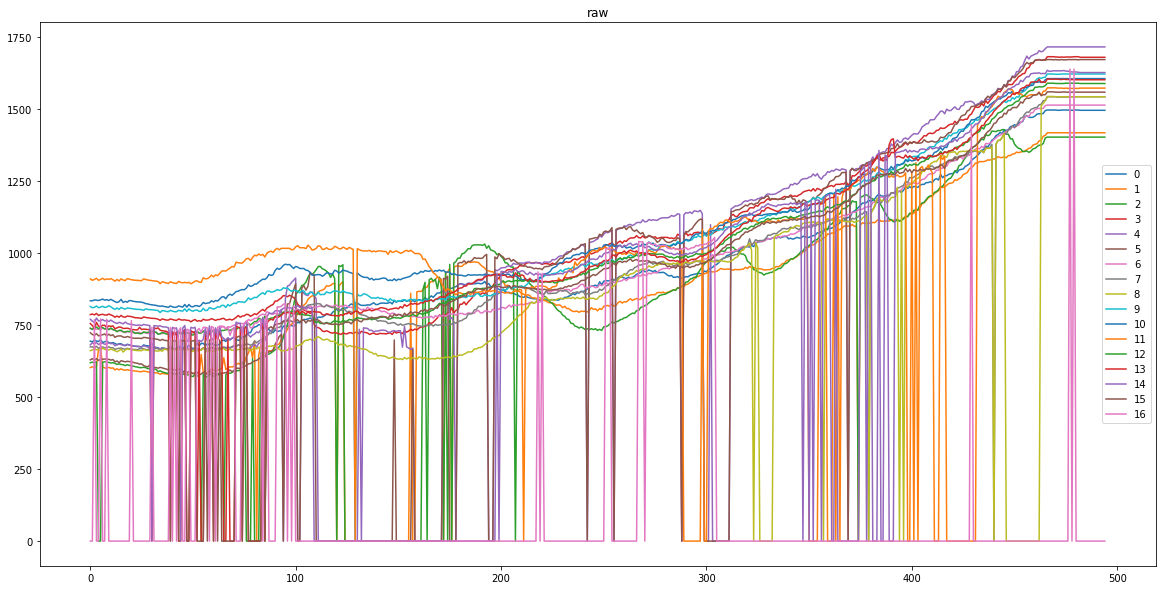

/Volumes/Nina Backup/high_quality_testing/batter/cole_loncar.mp4


In [ ]:
#name = "#48 RHP Tom Flippin 6-3 GO"
vid_path = "/Volumes/Nina Backup/high_quality_testing/batter/"
path = "/Volumes/Nina Backup/high_quality_testing/batter_outputs/"
#path = "/Volumes/Nina Backup/Nina's Pitch/multiple bboxes/"
# path= "/Volumes/Nina Backup/Nina's Pitch/"
options = ["_raw", "_interpolate", "_erosion"]
outputs = path #+ "multiple bboxes/" #"./sv/v0testing/" # + "handle_one_old/"
argmin_list = []
# df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one/"+name+".csv", dtype = {"Frame": np.int32, "Batter": np.ndarray})

# fi = "/Volumes/Nina Backup/high_quality_outputs/#3 Cole Loncar.json"
for json_file in ["cole_loncar.json"]: #listdir(outputs): #: ["#26 RHP Tim Willites (3).json"]
    name = json_file[:-5]
    if json_file[-5:]!= ".json":# or json_file[0]=="." or name+"_smooth.json" in listdir(outputs):# or "Zac" in name:
        print("wrong", json_file)
        continue
    print(name+".mp4")
    #with open(outputs+ name+".json", "r") as infile:
     #   handle_one_arr = json.load(infile)
    handle_one_arr = from_json(outputs+ name+".json") # [:300]
    #if name+".mp4" in listdir(path+"batter"):
     #   f = path+"batter/"+name+".mp4"
    #else:
     #   f = path+"pitcher/"+name+".mp4"
    #name = "#5 RHP Matt Blais (4)"
    #40mph_10us_11f_100fps_noisy  #"40mph_1us_1.2f_170fps_40m_sun # 40mph_10us_6f_100fps_40m_cloudy
    #f = path+ "40mph_10us_6f_100fps_40m_cloudy"+".avi"
    # f = name+".avi"
    f = vid_path + json_file[:-5] + ".mp4"
    #f = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter/#3 Cole Loncar.mp4"
    print(handle_one_arr.shape)
    print(np.array(handle_one_arr[0]).shape)
    print(f)

    #local_out = [elem.tolist() for elem in new_df]
        
    #with open(outputs+name+"_local.json", "w") as outfile:
     #   json.dump(local_out, outfile)
    

    #print(handle_one_arr[200:205])
    #arr = color_video(handle_one_arr, f, start = 150, end = 155, cut_frame = False, plotting = True)#len(handle_one_arr)) #, printing = argmin_list)
    #break
    # skvideo.io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one_bsp.mp4", arr)
    
    new_df = handle_one_arr #[:, :12,:] # das wieder rein und vier untere zeilen raus
    print(new_df.shape)
    
    
    plt.figure(figsize=(20,10))
    for i in range(len(new_df[0])):
        plt.plot(new_df[:,i,0], label = i)
    plt.legend()
    plt.title("raw")
    plt.show()
    
    if False:
        # new_df = interpolate(new_df)
        b_new_df = mix_right_left(new_df.copy())
        b_new_df = filter_bspline(b_new_df, knot_dist=10)

        #print(new_df[:3])
        plt.figure(figsize=(20,10))
        for i in range(len(new_df[0])):
            plt.plot(b_new_df[:,i,0], label = i)
        plt.legend()
        plt.title("curve fitting")
        plt.show()

        arr2 = color_video(b_new_df, f, start = 0, cut_frame=False, end =len(new_df), printing = None, plotting=False)
        io.vwrite(outputs+name+"_bsplinefit"+".mp4", arr2)

        # to_json(new_df, {}, outputs+name+"_smooth")
        # continue

    #arr2 = color_video(new_df[:,:12,:], f, start = 0, cut_frame=False, end =2, printing = None, plotting=True)      
    #sys.exit()
    
    for i in range(3):
        if i>0:
            
            if i==1:
                new_df = interpolate(new_df)
                plt.figure(figsize=(20,10))
                for l in range(len(new_df[0])):
                    plt.plot(new_df[:,l,0], label = l)
                plt.legend()
                plt.title("interpolated")
                plt.show()
            
            if i>1:
                ### SMOOTHING
                for k in range(len(new_df[0])):
                    for j in range(2):
                        #print(new_df[:,i,j].tolist())
                        new_df[:,k,j] = lowpass(new_df[:,k,j]-new_df[0,k,j], cutoff = 1, fs = 20)+new_df[0,k,j]
                        # new_df[:,i,j] = smooth_estelle(new_df[:,i,j]-new_df[0,i,j],window_len=10,window='flat')+new_df[0,i,j] #, window_len = 12, window = "flat")
                        # new_df[:,i,j] = kalmann(new_df[:,i,j]) #
                        # new_df[:,i,j] = get_median_filtered(new_df[:,i,j]-new_df[0,i,j])+new_df[0,i,j]
                        # continue
                #df_handle = [handle_one_arr, handle_one_arr.copy()]
                #new_df = new_df[50:]
                #center = [dictionary[name][1],dictionary[name][0]] #[83, 102] # [ 182.,  601.] #
                #new_df = np.array(df_coordinates(df_handle, np.array([center]), player_list)[1])
                #print("out_df", np.array(new_df).shape)
                #print(f)
                # new_df = ndimage.filters.gaussian_filter1d(np.array(new_df), axis = 0, sigma = 3)
                #print(new_df.shape)
                plt.figure(figsize=(20,10))
                plt.plot(new_df[:,:len(new_df[0]),0])
                plt.title("smoothed lowpass")
                plt.show()
                #to_json(new_df, {}, outputs+name+"_smooth")
        arr2 = color_video(new_df[:,:12,:], f, start = 0, cut_frame=False, end =len(new_df), printing = None, plotting=False)
        io.vwrite(outputs+name+options[i]+".mp4", arr2)

In [ ]:
#name = "#48 RHP Tom Flippin 6-3 GO"
#path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"
path = "/Volumes/Nina Backup/CENTERFIELD/"
outputs = "sv/test_outputs/" #path# + "handle_one_old/"
argmin_list = []
# df = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one/"+name+".csv", dtype = {"Frame": np.int32, "Batter": np.ndarray})
for json_file in ["fb2d39a6-49f9-4204-969b-1e0fbdfab7da_handle_one.json"]: #listdir(outputs):
    name = json_file.split("_")[0]
    if json_file[-5:]!= ".json" or json_file[-10:]=="local.json": # or name+".mp4" in listdir(outputs):
        print("wrong", json_file)
        continue
    print(name+".mp4")
    with open(outputs+json_file, "r") as infile:
        handle_one_arr = json.load(infile)
    #handle_one_arr = from_json(outputs+ name+".json")
    """
    if name+".mp4" in listdir(path+"batter"):
        f = path+"batter/"+name+".mp4"
    elif name+".mp4" in listdir(path+"batter"):
        f = path+"batter/"+name+".mp4"
    """
    f = path+name.split("_")[0]+".mp4"
    #name = "#5 RHP Matt Blais (4)"
    print(len(handle_one_arr))
    #print(np.array(handle_one_arr[0]).shape)
    print(f)
        
    for i in range(len(handle_one_arr)):
        handle_one_arr[i]=np.array(handle_one_arr[i])
    #with open(outputs+name+"_local.json", "w") as outfile:
     #   json.dump(local_out, outfile)
    
    #arr = color_video(handle_one_arr, f, start = 110, end = 120, point = 2, plotting = True)#len(handle_one_arr)) #, printing = argmin_list)
    #io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/handle_one_bsp.mp4", arr)
    
    df_handle = [handle_one_arr, handle_one_arr.copy()]
    # print(handle_one_arr[0])
    # CENTER WITH BOTTOM_TOP; LEFT_RIGHT
    center = [141,108] #[dictionary[name][1],dictionary[name][0]] #[83, 102] # [ 182.,  601.] #
    new_df = np.array(df_coordinates(df_handle, np.array([center]), player_list)[1])
    print("out_df", np.array(new_df).shape)

    # arr2 = color_video(new_df[:,:12,:], f, start = 130, end =135, point = 2, printing = None, plotting=True)
    #io.vwrite(outputs+name+"_kalmann_stronger.mp4", arr2)
    

In [ ]:
def color_video_two(json_array1, json_array2, vid_file, start = 0, end = 300, printing =None, plotting=True):
    colors = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 170, 255],
              [0, 0, 0], 
          [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], 
              [0, 85, 255],  [85, 0, 255], 
          [170, 0, 255], [255, 0, 170], [255, 0, 85], [255, 0, 85], [0, 255, 170],  [0, 170, 255], [0, 85, 255],  [85, 0, 255], \
          [170, 0, 255], [255, 0, 170], [255, 0, 85]]
    colors_string = ["blue", "green", "red", "tuerkis", "pink", "yellow", "orange", "black", "purple"]
    nr_joints =12
    #print(json_array.shape)
    #writer = cv2.VideoWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi",cv2.VideoWriter_fourcc(*"XVID") , 20, (500,800))

    #writer = io.FFmpegWriter("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/test.avi", (10,800,500,3))
    #writer.open()
    video_capture = cv2.VideoCapture(vid_file)
    print(vid_file)
    if start!=0:
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start)
    arr = [] #np.zeros((100,800,500,3))
    
    bottom_b = 265
    left_b =499
    right_b= 703
    top_b = 99
    
    # fig = plt.figure(figsize=(5, 15)) # for subplots
    for k in range(start, end):
        #print(k)
        if printing!=None:
            #print("dist_min",  "ratio_min")
            #print(colors_string[printing[k][0]], colors_string[printing[k][1]])
            print(printing[k])
        ret, frame = video_capture.read()
        if frame is None:
            print("end", k)
            break
        if len(json_array1[k].shape)==2:
            all_peaks = np.reshape(json_array1[k], (12, 1,2))
            all_peaks2 = np.reshape(json_array2[k], (12, 1,2))
        else:
            all_peaks = json_array1[k]
            all_peaks2 = json_array2[k]
        #print(all_peaks.shape)
        
        canvas = frame #[top_b:bottom_b, left_b:right_b] # cv2.imread(f) # B,G,R order
        oriImg = canvas.copy()
        
        for i in range(len(all_peaks)):
            #print("person", all_peaks[i])
            for j in range(len(all_peaks[i])):
                cv2.circle(canvas, (int(all_peaks[i,j,0]),int(all_peaks[i,j,1])) , 2, colors[i], thickness=-1)
                cv2.circle(canvas, (int(all_peaks2[i,j,0]),int(all_peaks2[i,j,1])) , 2, colors[i], thickness=-1)
                

        to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
        arr.append(to_plot[:,:,[2,1,0]])
        if plotting:
            plt.imshow(to_plot[:,:,[2,1,0]])
            fig = matplotlib.pyplot.gcf()
            fig.set_size_inches(12, 12)
            plt.show()
    return np.array(arr)


def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

#arr2 = color_video(new_df[:,:12,:], f, start = 100, end =105, printing = None, plotting=True)



In [ ]:
game = "fb2d39a6-49f9-4204-969b-1e0fbdfab7da.mp4" 
folder = "sv/test_outputs/"
#print(folder+game[:-4]+"_batter.json")
#print(game[:-4]+"_batter.json" in listdir("sv/"))
#print(listdir("sv/test_outputs/"))
new_df = from_json(folder+game[:-4]+"_batter.json")

#print(new_df.shape)
#print(new_df[:20])
f = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"+game #83764a69-2028-4530-8188-f7c37162d403.mp4"

new_df2 = from_json(folder + game[:-4]+"_pitcher.json")
print(new_df.shape, new_df2.shape)
arr2 = color_video_two(new_df[:,:12,:],new_df2[:,:12,:], f, start = 0, end =len(new_df), printing = None, plotting=False)
print(arr2.shape)
io.vwrite(folder+game, arr2)

In [ ]:
folder = "/Volumes/Nina Backup/outputs/sv_new/"
video_folder = "/Volumes/Nina Backup/outputs/CH_HIGH_SIDEVIEW/"
game_id = "490108" #"490770"
dic = {"490795": "2017-05-24", "490493":"2017-05-02", "490987":"2017-06-07", "491122":"2017-06-17", "491001":"2017-06-08", "491465":"2017-07-16"}
if folder[-3:]=="cf/":
    ext = ".mp4"
    view = "center field/"
else:
    ext = ".m4v"
    view = "side view/"
folder_list = listdir(folder)
for game in folder_list:
    if "batter" in game:
        print(game)
        continue
    print(game)
    #print(dic[game[:6]])
    if "new" in folder:
        name = game.split("_")[1]
        begin = game.split("_")[0]
        json_name = begin+"_"+name
        if begin!=game_id:
            continue
        print(begin, json_name, name)
    else:
        video_folder = "/Volumes/Nina Backup/videos/atl/"+dic[game[:6]]+"/"+view
        #print(listdir(video_folder))
        json_name= name = game.split("_")[0]
        
    if name+ext in folder_list:
        print("already there", name)
        continue
    try:
        new_df = from_json(folder+json_name+"_batter.json")
    except FileNotFoundError:
        print("only pitcher copied")
        continue
    new_df2 = from_json(folder + json_name+"_pitcher.json")

    f = video_folder+name+ext #83764a69-2028-4530-8188-f7c37162d403.mp4"

    print(new_df.shape, new_df2.shape)
    arr2 = color_video_two(new_df[:,:12,:],new_df2[:,:12,:], f, start = 0, end =len(new_df), printing = None, plotting=False)
    print(arr2.shape)
    io.vwrite(folder+name+ext, arr2)

# Save colored video from directory

In [ ]:
from os import listdir
dire = listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/")
for fi in dire:
    filename = fi.split("_")[0] #"#33 Logan Trowbridge"
    print(filename)
    if filename[-4:]==".mp4": #or filename+".mp4" in dire:
        print("already there")
        continue
    if filename+".mp4" in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter"):
        player = "batter/"
    else:
        player = "pitcher/"


    colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 0, 0], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]


    cmap = matplotlib.cm.get_cmap('hsv')

    vid_file = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/"+player+filename+".mp4"
    json_array = from_json("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"+filename+"_joints.json")
    # = np.swapaxes(np.load("/Users/ninawiedemann/Desktop/UNI/Praktikum/handle_one_bsp.npy"), 0,1)
    nr_joints = 12
    print(json_array.shape)


    arr = color_video(json_array, vid_file, plotting = False)
    skvideo.io.vwrite("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/outputs_example/"+filename+".mp4", arr)

# Build center dic

In [ ]:
#with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "r") as infile:
 #   dictionary = json.load(infile)

in_folder = listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher")
for i in in_folder:
    if i[:-4] not in dictionary.keys():
        print(i)

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter/"
f = '#25 Trevor DeMerritt rbi base hit.mp4'
print(f[:-4] in dictionary.keys())

center = dictionary[f[:-4]] #[1200,650]
cap  = cv2.VideoCapture(path+f)
ret, frame = cap.read()
cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
plt.imshow(frame)
plt.show()

dictionary[f[:-4]]=center

### Test for all files

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"

for fi in dictionary.keys():
    f = fi+'.mp4'
    print(f)
    # print(f[:-4] in dictionary.keys())
    if f in listdir("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/batter"):
        continue
    center = dictionary[fi] #[700,650]
    print(center)

    cap  = cv2.VideoCapture(path+f)
    ret, frame = cap.read()
    cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
    plt.imshow(frame)
    plt.show()

    #dictionary[f[:-4]]=center

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "w") as outfile:
    json.dump(dictionary, outfile)

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/center_dics.json", "r") as infile:
    dictionary = json.load(infile)

In [ ]:
path = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"
f = '#5 RHP Matt Blais (3).mp4'
print(f[:-4] in dictionary.keys())

center = dictionary[f[:-4]] #[1200,650]
cap  = cv2.VideoCapture(path+f)
i = 0
while True:
    ret, frame = cap.read()
    if frame is None:
        print(i-1)
        plt.imshow(prev_frame)
        plt.show()
        break
    # cv2.circle(frame, (int(center[0]),int(center[1])) , 15, [255, 0, 0], thickness=-1)
    prev_frame = frame
    i+=1

In [ ]:
with open("/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/test_functions.json","r") as infile:
    images = json.load(infile)
print(len(images))

In [ ]:
for i in images:
    plt.imshow(i)
    plt.show()

In [ ]:
from osgeo import ogr

In [ ]:
vid_file = "/Volumes/Nina Backup/Nina's Pitch/40mph_10us_6f_100fps_40m_cloudy.avi"
video_capture = cv2.VideoCapture(vid_file)
video_capture.set(cv2.CAP_PROP_POS_FRAMES, 85)
ret, frame = video_capture.read()
plt.imshow(frame)
plt.show()
cv2.imwrite("/Volumes/Nina Backup/Nina's Pitch/cloudy_before.jpg", frame)

In [ ]:
from scipy.misc import imresize
ori_shape = frame.shape[:2]
for i in range(1,20,2):
    print(i)
    shaped = imresize(frame, (int(ori_shape[0]*(i/20)), int(ori_shape[1]*(i/20)), 3))
    plt.imshow(shaped)
    plt.show()

In [ ]:
l = [1063.0, 1063.0, 1065.0, 1071.0, 1061.0, 1061.0, 1062.0, 1061.0, 1061.0, 1061.0, 1061.0, 1062.0, 1061.0, 1072.0, 1060.0, 1061.0, 1061.0, 1062.0, 1061.0, 1070.0, 1063.0, 1061.0, 1062.0, 1062.0, 1062.0, 1062.0, 1063.0, 1063.0, 1063.0, 1062.0, 1062.0, 1062.0, 1063.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1072.0, 1071.0, 1071.0, 1072.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1072.0, 1071.0, 1072.0, 1072.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1072.0, 1072.0, 1064.0, 1064.0, 1071.0, 1071.0, 1071.0, 1071.0, 1064.0, 1072.0, 1063.0, 1063.0, 1063.0, 1071.0, 1071.0, 1071.0, 1063.0, 1063.0, 1071.0, 1071.0, 1063.0, 1072.0, 1071.0, 1063.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1071.0, 1072.0, 1072.0, 1072.0, 1071.0, 1072.0, 1071.0, 1071.0, 1062.0, 1071.0, 1069.0, 1069.0, 1071.0, 1069.0, 1068.0, 1059.0, 1069.0, 1066.0, 1068.0, 1058.0, 1058.0, 1058.0, 1055.0, 1057.0, 1065.0, 1065.0, 1056.0, 1065.0, 1053.0, 1064.0, 1062.0, 1055.0, 1064.0, 1062.0, 1058.0, 1057.0, 1061.0, 1060.0, 1060.0, 1049.0, 1058.0, 1058.0, 1049.0, 1057.0, 1056.0, 1057.0, 1046.0, 1055.0, 1057.0, 1055.0, 1055.0, 1056.0, 1055.0, 1055.0, 1055.0, 1055.0, 1055.0, 1044.0, 1054.0, 1050.0, 1042.0, 1051.0, 1052.0, 1053.0, 1050.0, 1051.0, 1037.0, 1037.0, 1047.0, 1048.0, 1039.0, 1047.0, 1034.0, 1044.0, 1031.0, 1032.0, 1029.0, 1029.0, 1027.0, 1030.0, 1025.0, 1025.0, 1014.0, 1013.0, 1037.0, 1036.0, 1034.9, 1033.8, 1032.7, 1031.6, 1030.4, 1029.3, 1028.2, 1027.1, 1026.0, 1024.9, 1023.8, 1022.7, 1021.6, 1020.4, 1019.3, 1018.2, 1017.1, 1016.0, 1029.0, 1016.0, 1022.0, 1013.0, 961.0, 951.0, 957.0, 943.0, 940.0, 936.0, 936.0, 921.0, 926.0, 928.0, 947.0, 926.0, 925.0, 926.0, 909.0, 906.3, 903.6, 900.9, 898.1, 895.4, 892.7, 890.0, 904.0, 893.0, 892.0, 895.0, 907.0, 903.0, 895.0, 898.0, 895.0, 898.0, 891.0, 904.0, 907.0, 898.0, 903.0, 905.0, 905.0, 909.0, 910.0, 902.0, 1041.0, 906.0, 905.0, 908.0, 906.0, 891.0, 894.0, 894.0, 887.0, 887.0, 882.0, 882.0, 872.0, 883.0, 872.0, 871.0, 863.0, 874.0, 871.0, 859.0, 858.0, 852.0, 855.0, 855.0, 852.0, 851.0, 840.0, 856.0, 857.0, 843.0, 844.0, 847.0, 849.0, 859.0, 854.5, 850.0, 845.5, 841.0, 851.0, 847.0, 844.0, 856.0, 845.0, 861.0, 845.0, 860.0, 851.0, 853.0, 856.0, 857.0, 856.0, 854.5, 853.0, 851.5, 850.0, 606.0, 669.0, 732.0, 795.0, 858.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0, 864.0]
plt.plot(l)
plt.show()

In [ ]:
l2 = [1226.0, 1205.0, 1194.0, 1208.0, 1195.0, 1196.0, 1196.0, 1196.0, 1196.0, 1196.0, 1194.0, 1196.0, 1195.0, 1199.0, 1195.0, 1197.0, 1196.0, 1197.0, 1195.0, 1206.0, 1195.0, 1196.0, 1197.0, 1198.0, 1198.0, 1199.0, 1199.0, 1199.0, 1198.0, 1197.0, 1198.0, 1195.0, 1198.0, 1208.0, 1207.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1207.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1208.0, 1207.0, 1206.0, 1197.0, 1197.0, 1208.0, 1208.0, 1207.0, 1200.0, 1196.0, 1204.0, 1196.0, 1195.0, 1195.0, 1208.0, 1207.0, 1197.0, 1196.0, 1195.0, 1208.0, 1201.0, 1195.0, 1209.0, 1199.0, 1196.0, 1209.0, 1208.0, 1208.0, 1208.0, 1209.0, 1208.0, 1208.0, 1207.0, 1208.0, 1208.0, 1209.0, 1209.0, 1209.0, 1196.0, 1208.0, 1206.0, 1208.0, 1206.0, 1209.0, 1207.0, 1195.0, 1209.0, 1205.0, 1207.0, 1196.0, 1195.0, 1197.0, 1194.0, 1204.0, 1206.0, 1206.0, 1195.0, 1206.0, 1192.0, 1206.0, 1192.0, 1193.0, 1206.0, 1192.0, 1204.0, 1190.0, 1204.0, 1207.0, 1209.0, 1191.0, 1207.0, 1210.0, 1205.0, 1220.0, 1207.0, 1208.0, 1211.0, 1220.0, 1227.0, 1205.0, 1221.0, 1207.0, 1224.0, 1205.0, 1221.0, 1206.0, 1222.0, 1207.0, 1222.0, 1206.0, 1220.0, 1222.0, 1222.0, 1223.0, 1221.0, 1222.0, 1204.0, 1219.0, 1206.0, 1220.0, 1202.0, 1220.0, 1202.0, 1221.0, 1204.0, 1219.0, 1202.0, 1204.0, 1202.0, 1221.0, 1205.0, 1201.0, 1188.0, 1185.0, 1179.0, 1196.0, 1184.0, 1179.0, 1176.0, 1180.0, 1160.0, 1177.0, 1155.0, 1157.0, 1187.0, 1174.0, 1160.0, 1174.0, 1154.0, 1156.0, 1156.0, 1156.0, 1158.0, 1137.0, 1156.0, 1136.0, 1156.0, 1133.0, 1116.0, 1167.0, 1172.0, 1170.0, 1154.0, 1152.0, 1027.0, 1025.0, 1148.0, 1165.0, 1128.0, 1147.0, 1146.0, 1128.0, 1128.0, 1126.0, 1111.0, 1124.0, 1122.0, 1096.0, 1105.0, 1103.0, 1084.0, 1088.0, 1087.0, 1070.0, 1085.0, 1085.0, 1066.0, 1050.0, 1062.0, 1053.0, 1031.0, 1031.0, 1033.0, 1040.0, 1063.0, 1043.0, 1045.0, 1047.0, 1029.0, 979.0, 947.0, 965.0, 951.0, 971.0, 968.0, 963.0, 0.0, 854.0, 867.0, 887.0, 863.0, 856.0, 849.0, 846.0, 850.0, 835.0, 824.0, 832.0, 830.0, 817.0, 835.0, 831.0, 824.0, 883.0, 895.0, 831.0, 879.0, 837.0, 818.0, 785.0, 802.0, 824.0, 797.0, 860.0, 825.0, 787.0, 792.0, 0.0, 0.0, 0.0, 784.0, 0.0, 0.0, 720.0, 0.0, 0.0, 702.0, 702.0, 0.0, 714.0, 0.0, 0.0, 724.0, 0.0, 0.0, 834.0, 825.0, 687.0, 831.0, 819.0, 680.0, 681.0, 677.0, 669.0, 674.0, 667.0, 669.0, 781.0, 796.0, 660.0, 797.0, 780.0, 652.0, 784.0, 775.0, 653.0, 644.0, 641.0, 643.0, 640.0, 642.0, 635.0, 625.0, 627.0]

In [ ]:
values = np.array(l2)
#print(values)

not_zer = ndimage.morphology.binary_erosion(values, iterations =2) #np.logical_not(values == 0)
plt.plot(values)
indices = np.arange(len(values))

values = np.round(
   np.interp(indices, indices[not_zer], values[not_zer]), 1)


plt.plot(values)
plt.show()

In [ ]:
new = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/csv_gameplay.csv", delimiter = ";")

In [ ]:
ids = new["play_id"].values
old_ids = old["play_id"].values
l = []
for i in ids:
    if not i in old_ids:
        l.append(i)
print(len(l))

In [ ]:
old = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data_cut.csv")

In [ ]:
print(len(ids), len(old_ids))

In [ ]:
print(len(np.unique(ids)))

In [ ]:
a = np.arange(10, 390, 5)
b = a[:-15].tolist()
b.append(390)
print(b)